<a href="https://colab.research.google.com/github/WagAtoguiaJr/churn_classifier_project.ipynb/blob/main/RID164783_Desafio06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

**Contexto**

A diretoria de uma plataforma de streaming está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn.

O objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

***Descrição dos dados:***

Os dados fornecidos possuem informações sobre as contas dos clientes na plataforma de streaming, divididos entre contas Basic, Standard e Premium, onde cada uma oferece uma gama maior de serviços que a anterior.

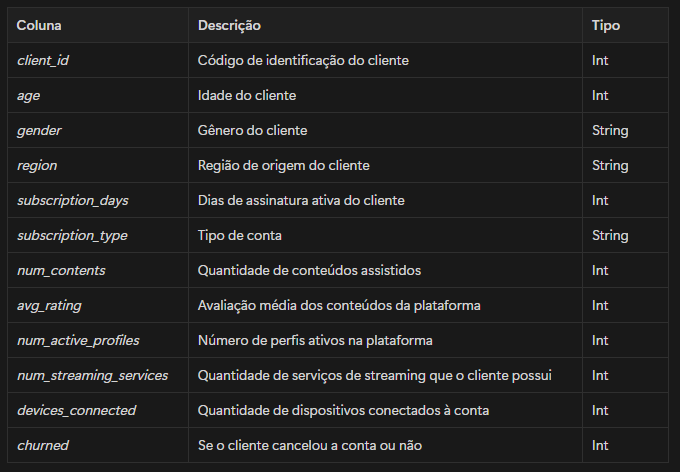

***Premissas de negócio:***

1. Substituir valores “NaN” por 0  nas colunas: Time_on_platform, Num_streaming_services, Churned, Avg_rating, Devices_connected;

2. Dropar linhas nulas nas colunas Gender, Subscription_type e Age;

3. Transformar os valores da coluna Churned  de 0 e 1 para No e Yes;

4. Tranformar os valores float em valores inteiros.

# Setup

Importando as bibliotecas e funções necessárias

In [ ]:
# Manipulação de dados e cálculos numéricos
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
# Configurando o tema das visualizações
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Data Understanding

Nesta etapa, o objetivo será o conhecimento dos dados: seus tipos, se há dados faltantes e alguma sujeira nos dados

In [ ]:
# Leitura da base de dados e visualização dos tipos de dados e presença de dados faltantes
df = pd.read_csv('/content/streaming_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
# Conhecendo o conteúdo de cada coluna
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [ ]:
# Fazendo uma análise descritiva dos dados numéricos
df.select_dtypes(include='number').describe().round(3)

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000,56464.000,52696.000,9572.000,77884.000,60614.000,61148.000
mean,43.511,4385.849,2.995,2.496,3.002,3.002,0.243
std,15.043,2526.581,1.414,1.121,1.413,1.155,0.429
min,18.000,0.000,1.000,1.000,1.000,1.000,0.000
25%,30.000,2196.000,2.000,1.000,2.000,1.990,0.000
50%,43.000,4384.000,3.000,2.000,3.000,3.010,0.000
75%,57.000,6573.000,4.000,4.000,4.000,4.000,0.000
max,69.000,8759.000,5.000,4.000,5.000,5.000,1.000


Pontos observados:


*   A coluna target (Churned) está no formato numérico, será necessário convertê-la mais tarde.
*   Olhando para a média e a mediana de cada coluna, infere-se que possivelmente não há outliers.



In [ ]:
# Verificando a quantidade de dados faltantes por coluna
df.isna().sum()

,0
Age,11277
Gender,14516
Time_on_platform,21420
Devices_connected,25188
Subscription_type,25221
Num_streaming_services,68312
Num_active_profiles,0
Avg_rating,17270
Churned,16736
User_id,0


Percebe-se uma quantidade significativa de dados nulos que deverá passar por um tratamento na fase seguinte.

# Data Preparation

Verificada a condição dos dados, nesta fase iniciar-se-á os devidos tratamentos.

## Tratando Dados Nulos

Primeiro, far-se-á a substituição (preenchimento) dos dados nulos das colunas Time_on_platform, Num_streaming_services, Churned, Avg_rating, Devices_connected, conforme as premissas de negócios acima destacadas.

In [ ]:
# Destacando quantidade de dados nulos nas colunas mencionadas
df[['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']].isna().sum()

,0
Time_on_platform,21420
Num_streaming_services,68312
Churned,16736
Avg_rating,17270
Devices_connected,25188


In [ ]:
# Fazendo o preenchimento dos valores nulos por 0
df[['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']] = df[['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']].fillna(value= 0)

In [ ]:
# Verificando o resultado
df[['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']].isna().sum()

,0
Time_on_platform,0
Num_streaming_services,0
Churned,0
Avg_rating,0
Devices_connected,0


In [ ]:
# Verificando na base de dados
df.isna().sum()

,0
Age,11277
Gender,14516
Time_on_platform,0
Devices_connected,0
Subscription_type,25221
Num_streaming_services,0
Num_active_profiles,0
Avg_rating,0
Churned,0
User_id,0


Com os preenchimentos devidamente feitos, agora, deve-se dropar as linhas cujos os valores das colunas Gender, Subscription_type e Age são nulos, conforme a segunda premissa de negócio.

In [ ]:
# Efetuando a exclusão das linhas
df.dropna(inplace=True)

In [ ]:
# Verificando o resultado
df.isna().sum()

,0
Age,0
Gender,0
Time_on_platform,0
Devices_connected,0
Subscription_type,0
Num_streaming_services,0
Num_active_profiles,0
Avg_rating,0
Churned,0
User_id,0


In [ ]:
# Devido a exclusão das linhas, torna-se necessário resetar os índices das linhas
df.reset_index(drop=True, inplace=True)

## Convertendo Dados Númericos

In [ ]:
# Verificando novamente os tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36515 entries, 0 to 36514
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  float64
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  float64
 3   Devices_connected       36515 non-null  float64
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  float64
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  float64
 9   User_id                 36515 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.8+ MB


De acordo com a descrição dos dados e as premissas de negócio, todos os dados numéricos devem ser do tipo inteiro ao invés de float. Com isso, deve-se operar a sua conversão para o tipo correto.

In [ ]:
# Realizando a conversão
df[df.select_dtypes(include='float').columns] = df.select_dtypes(include='float').astype(int)

In [ ]:
# Checando os resultados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36515 entries, 0 to 36514
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     36515 non-null  int64 
 1   Gender                  36515 non-null  object
 2   Time_on_platform        36515 non-null  int64 
 3   Devices_connected       36515 non-null  int64 
 4   Subscription_type       36515 non-null  object
 5   Num_streaming_services  36515 non-null  int64 
 6   Num_active_profiles     36515 non-null  int64 
 7   Avg_rating              36515 non-null  int64 
 8   Churned                 36515 non-null  int64 
 9   User_id                 36515 non-null  object
dtypes: int64(7), object(3)
memory usage: 2.8+ MB


Por fim, vamos substituir os 0 e 1 da coluna Churned por No e Yes, respectivamente.

In [ ]:
# Convertendo para tipo texto e efetuando a substituição dos valores
df['Churned'] = df['Churned'].astype(str).replace({'0': 'No', '1': 'Yes'})

In [ ]:
# Checando a conversão
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36515 entries, 0 to 36514
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     36515 non-null  int64 
 1   Gender                  36515 non-null  object
 2   Time_on_platform        36515 non-null  int64 
 3   Devices_connected       36515 non-null  int64 
 4   Subscription_type       36515 non-null  object
 5   Num_streaming_services  36515 non-null  int64 
 6   Num_active_profiles     36515 non-null  int64 
 7   Avg_rating              36515 non-null  int64 
 8   Churned                 36515 non-null  object
 9   User_id                 36515 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.8+ MB


In [ ]:
# Verificando o resultado da substituição
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,54,Male,3024,2,Basic,0,1,0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [ ]:
# Conhecendo as classes de cada coluna categórica, no intuito de detectar qualquer sujeira
for col in list(df.select_dtypes(exclude= 'number').drop(columns='User_id')):
  print(f'{col}:', list(df[col].unique()))
  print()

Gender: ['Male', 'Female']

Subscription_type: ['Basic', 'Standard', 'Premium']

Churned: ['No', 'Yes']



## Fazendo uma análise exploratória com os dados pós-tratamento

Com os dados limpos, fica fácil poder analisá-los e detectar qualquer padrão nos dados.

### Variáveis Categóricas


Churned
No     29459
Yes     7056
Name: User_id, dtype: int64


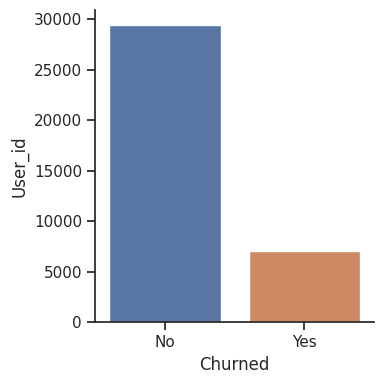

In [ ]:
agg = df.groupby('Churned')['User_id'].count().sort_values(ascending= False)

sns.catplot(
    data = agg.reset_index(),
    x = 'Churned',
    y = 'User_id',
    kind= 'bar',
    hue= 'Churned',
    height= 4,
    aspect= 1
);

print()
print(agg)

Percebe-se que a base de dados é desbalanceada, com uma significativa maioria de casos de "não-churn".


Gender
Male      18366
Female    18149
Name: User_id, dtype: int64


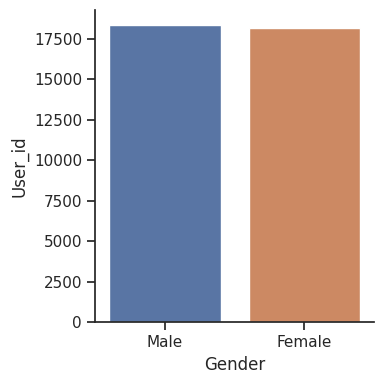

In [ ]:
agg = df.groupby('Gender')['User_id'].count().sort_values(ascending= False)

sns.catplot(
    data = agg.reset_index(),
    x = 'Gender',
    y = 'User_id',
    kind= 'bar',
    hue= 'Gender',
    height= 4,
    aspect= 1
);

print()
print(agg)

Observa-se uma distribuição quase igualitária entre homens e mulheres, embora a quantidade do sexo masculino seja a maioria.


Subscription_type
Premium     12224
Standard    12157
Basic       12134
Name: User_id, dtype: int64


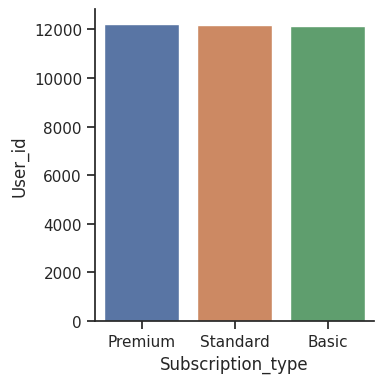

In [ ]:
agg = df.groupby('Subscription_type')['User_id'].count().sort_values(ascending= False)

sns.catplot(
    data = agg.reset_index(),
    x = 'Subscription_type',
    y = 'User_id',
    kind= 'bar',
    hue= 'Subscription_type',
    height= 4,
    aspect= 1
);

print()
print(agg)

Aparentemente, é o mesmo caso para os tipos de assinatura. Com a maioria sendo de assinaturas Premium, uma leve liderança.

Faz-se necessário agora cruzar essas duas colunas com a coluna target (Churned), a fim de notar a presença de algum padrão que permita discernir quem dará churn e quem não.


Churned  Gender
No       Male      14798
         Female    14661
Yes      Male       3568
         Female     3488
Name: User_id, dtype: int64


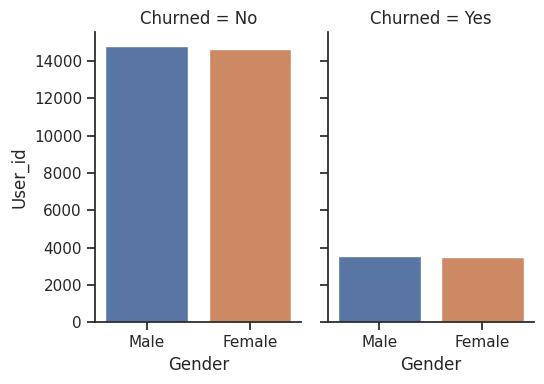

In [ ]:
agg = df.groupby(['Churned', 'Gender'])['User_id'].count().sort_values(ascending= False)

sns.catplot(
    data = agg.reset_index(),
    x = 'Gender',
    y = 'User_id',
    kind= 'bar',
    hue= 'Gender',
    col= 'Churned',
    height= 4,
    aspect= .7
);

print()
print(agg)

Continua com mesma proporção geral. Ou seja, ambos os sexos estão representados quase que igualitariamente nas duas situações.


Churned  Subscription_type
No       Premium              9866
         Standard             9847
         Basic                9746
Yes      Basic                2388
         Premium              2358
         Standard             2310
Name: User_id, dtype: int64


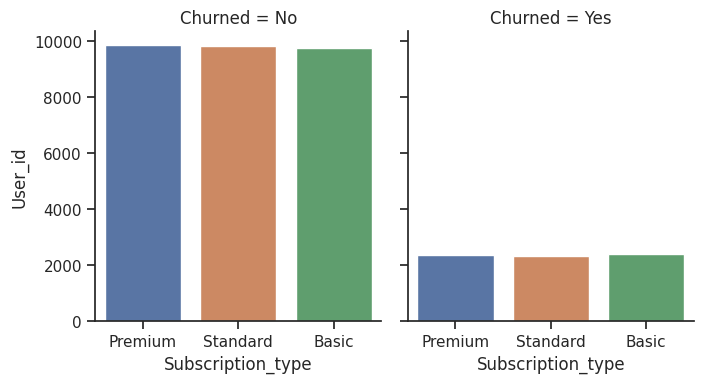

In [ ]:
agg = df.groupby(['Churned', 'Subscription_type'])['User_id'].count().sort_values(ascending= False)

sns.catplot(
    data = agg.reset_index(),
    x = 'Subscription_type',
    y = 'User_id',
    kind= 'bar',
    hue= 'Subscription_type',
    col= 'Churned',
    height= 4,
    aspect= .9
);

print()
print(agg)

Aqui quase que a mesma proporção geral. Porém, os assinantes Basic são os que mais abandonam a plataforma. Contudo, deve-se destacar que se trata de uma diferença pequena, tendo como base o todo.

### Variáveis Numéricas

In [ ]:
df.select_dtypes(include= 'number').describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Age,36515.0,43.473,15.092,18.0,30.0,43.0,57.0,69.0
Time_on_platform,36515.0,3170.232,2909.245,0.0,0.0,2708.0,5741.0,8759.0
Devices_connected,36515.0,2.040,1.821,0.0,0.0,2.0,4.0,5.0
Num_streaming_services,36515.0,0.309,0.910,0.0,0.0,0.0,0.0,4.0
Num_active_profiles,36515.0,2.993,1.413,1.0,2.0,3.0,4.0,5.0
Avg_rating,36515.0,1.951,1.435,0.0,1.0,2.0,3.0,5.0


Percebe-se que mesmo após o tratamento, as médias e medianas não se alteraram. E, a ideia que não há outliers continua.

Através de uma Pivot Table, verificar-se-á a presença de um padrão ou não cruzando as métricas com a coluna Churned.

In [ ]:
agg_dict = {
    'Age': ['mean', 'median', 'std', 'max', 'min'],
    'Time_on_platform': ['mean', 'median', 'std', 'max', 'min'],
    'Avg_rating': ['mean', 'median', 'std', 'max', 'min']
}


pivot_table_result = df.pivot_table(index='Churned', aggfunc=agg_dict).round(2)

display(pivot_table_result)

Age                          Avg_rating                         \
        max   mean median min    std        max  mean median min   std   
Churned                                                                  
No       69  43.47   43.0  18  15.08          5  1.94    2.0   0  1.43   
Yes      69  43.47   43.5  18  15.13          5  1.98    2.0   0  1.44   

        Time_on_platform                                
                     max     mean  median min      std  
Churned                                                 
No                  8759  3180.06  2742.0   0  2911.58  
Yes                 8758  3129.20  2583.5   0  2899.31

In [ ]:
agg_dict = {
    'Devices_connected': ['sum', 'mean', 'median', 'max', 'min'],
    'Num_streaming_services': ['sum', 'mean', 'median', 'max', 'min'],
    'Num_active_profiles': ['sum', 'mean', 'median', 'max', 'min'],
}


pivot_table_result = df.pivot_table(index='Churned', aggfunc=agg_dict).round(2)

display(pivot_table_result)

Devices_connected                         Num_active_profiles        \
                      max  mean median min    sum                 max  mean   
Churned                                                                       
No                      5  2.04    2.0   0  60011                   5  2.99   
Yes                     5  2.05    2.0   0  14466                   5  3.00   

                          Num_streaming_services                         
        median min    sum                    max  mean median min   sum  
Churned                                                                  
No         3.0   1  88167                      4  0.31    0.0   0  9000  
Yes        3.0   1  21139                      4  0.33    0.0   0  2299

Após a análise das tabelas, infere-se que não existe uma diferença clara entre os casos negativos e positivos.

Verificando se de fato não há qualquer outlier

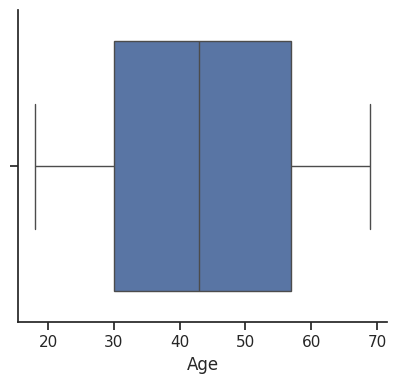

In [ ]:
agg = df[['Age']]

sns.catplot(
    data= agg,
    x= 'Age',
    kind= 'box',
    height= 4,
    aspect= 1
);

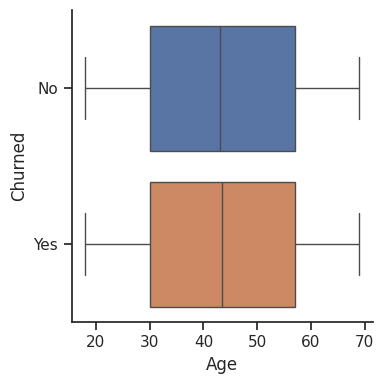

In [ ]:
agg = df[['Churned', 'Age']]

sns.catplot(
    data= agg,
    x= 'Age',
    y= 'Churned',
    kind= 'box',
    hue= 'Churned',
    height= 4,
    aspect= 1
);

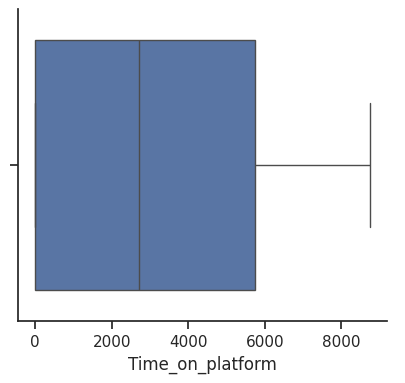

In [ ]:
agg = df[['Time_on_platform']]

sns.catplot(
    data= agg,
    x= 'Time_on_platform',
    kind= 'box',
    height= 4,
    aspect= 1
);

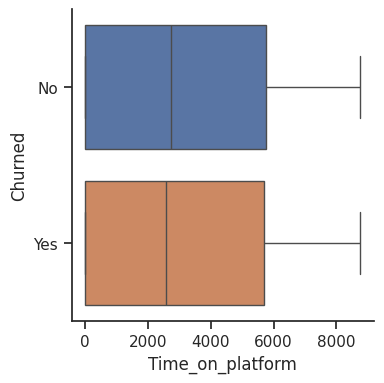

In [ ]:
agg = df[['Churned', 'Time_on_platform']]

sns.catplot(
    data= agg,
    x= 'Time_on_platform',
    y= 'Churned',
    kind= 'box',
    hue= 'Churned',
    height= 4,
    aspect= 1
);

Após checagem, definitivamente não há qualquer outlier nos dados.

**Pontos observados após análise exploratória dos dados:**



*   A base de dados é bem desbalanceada, possuindo mais casos negativos do que positivos.
*   O perfil dos casos positivos e o dos casos negativos não se diferem praticamente em nada, o que pode comprometer os modelos de predição.



# Modelling

Embora os pontos destacados acima, continuar-se-á com a construção dos modelos de predição.

## Data Splitting/Preprocessing

Nesta etapa, os dados serão separados e pré-processados antes de passá-los para os modelos.

In [ ]:
# Separando os dados
X = df.drop(columns=['User_id', 'Churned']).copy()
y = df[['Churned']].copy()

In [ ]:
# Dummificando as variáveis categóricas
X = pd.get_dummies(data= X, dtype= int)
X.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard
0,49,4700,3,0,3,0,0,1,1,0,0
1,69,6107,2,0,1,2,1,0,0,0,1
2,44,6374,3,1,1,1,0,1,0,1,0
3,26,0,5,0,2,0,0,1,1,0,0
4,54,3024,2,0,1,0,0,1,1,0,0


In [ ]:
# Instancionando e treinando o encodificador que dummificará a variável target
encoder = LabelEncoder()
encoder.fit(y.Churned)

LabelEncoder()

In [ ]:
# Dummificando a variável target
y['Churned'] = encoder.transform(y.Churned)
y

,Churned
0,0
1,0
2,1
3,0
4,0
...,...
36510,0
36511,0
36512,1
36513,0


In [ ]:
# Separando os dados para treino e teste, aplicando uma estratificação para que haja as mesmas proporções de casos negativo e positivo
train_X, test_X, train_y, test_y = train_test_split(
    X, y,
    test_size= 0.3,
    stratify= y,
    random_state= 42
)

In [ ]:
# Instancionando e treinando o modelo de escalonamento dos dados
scaler = MinMaxScaler()
scaler.fit(train_X)

MinMaxScaler()

In [ ]:
# Escalonando os dados de treino e teste para que os dados de diferentes escalas não tenham pesos maiores
train_X_std = pd.DataFrame(data= scaler.transform(train_X), columns= X.columns, index= train_X.index)
test_X_std = pd.DataFrame(data= scaler.transform(test_X), columns= X.columns, index= test_X.index)

In [ ]:
train_X_std.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard
32366,0.843137,0.112456,0.0,0.0,0.00,0.6,1.0,0.0,0.0,1.0,0.0
7766,0.392157,0.957872,0.0,0.0,0.75,0.6,0.0,1.0,1.0,0.0,0.0
3536,0.450980,0.620505,0.6,0.0,1.00,0.4,0.0,1.0,0.0,1.0,0.0
24282,0.490196,0.903642,1.0,0.0,0.00,0.4,0.0,1.0,0.0,0.0,1.0
17993,0.549020,0.698710,0.8,0.5,1.00,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
test_X_std.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard
20640,0.901961,0.915972,0.0,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0
33798,0.470588,0.369334,0.2,0.0,0.25,0.8,1.0,0.0,0.0,1.0,0.0
18914,0.333333,0.000000,1.0,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0
29914,0.607843,0.000000,1.0,0.0,0.00,0.8,0.0,1.0,0.0,0.0,1.0
30727,0.529412,0.245918,1.0,0.0,0.50,0.6,1.0,0.0,0.0,0.0,1.0


## Model Trainning/Testing

Os modelos escolhidos para uso são:


*   Logistic Regression
*   Random Forest Classifier

O primeiro é mais simples do que o segundo, e será usado como parâmetro para verificar como se comportam os dados.

já o segundo é mais sofisticado, porém tem uma tendência a sofrer overfitting, ou seja ele "decora" os dados de treino e acaba não generalizando bem quando lida com dados novos.

### Logistic Regression

In [ ]:
# Treinando o modelo
lrc = LogisticRegression()
lrc.fit(train_X_std, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
# Coletando as predições de treino e de teste
train_predictions_lrc = lrc.predict(train_X_std)
test_predictions_lrc = lrc.predict(test_X_std)

In [ ]:
# Montando uma tabela de predição com os dados de teste e as predições de teste
table_prediction = test_X_std.assign(Prediction = test_predictions_lrc).assign(Real = test_y)
table_prediction.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Prediction,Real
20640,0.901961,0.915972,0.0,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,0,0
33798,0.470588,0.369334,0.2,0.0,0.25,0.8,1.0,0.0,0.0,1.0,0.0,0,1
18914,0.333333,0.000000,1.0,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,0,0
29914,0.607843,0.000000,1.0,0.0,0.00,0.8,0.0,1.0,0.0,0.0,1.0,0,0
30727,0.529412,0.245918,1.0,0.0,0.50,0.6,1.0,0.0,0.0,0.0,1.0,0,0


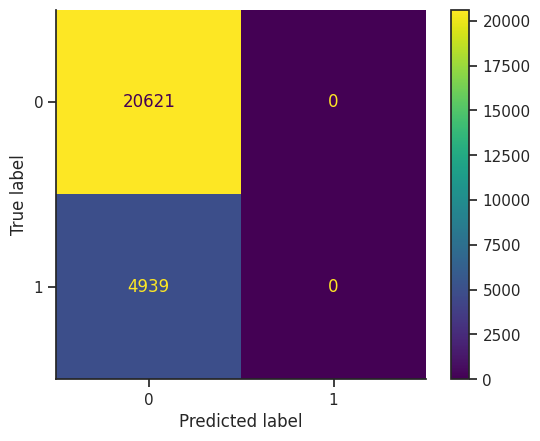

In [ ]:
# Plotando Matriz de Confunsão com as predições de treino
metrics.ConfusionMatrixDisplay.from_predictions(train_y, train_predictions_lrc);

Observe que o modelo não conseguiu rotular os casos positivos, ou seja ele não identificou quem deu churn.

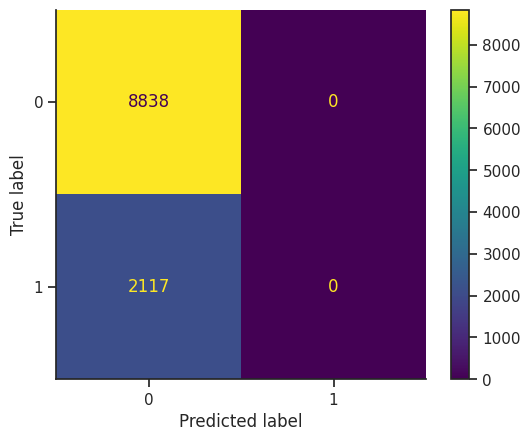

In [ ]:
# Plotando a matriz com as predições de teste
metrics.ConfusionMatrixDisplay.from_predictions(test_y, test_predictions_lrc);

In [ ]:
# Criando um dicionário com as métricas para treino e teste
metricas_lrc = {
    'model': ['Logistic Regression', 'Logistic Regression'],
    'modo': ['treino', 'teste'],
    'accuracy': [metrics.accuracy_score(train_y, train_predictions_lrc), metrics.accuracy_score(test_y, test_predictions_lrc)],
    'balanced accuracy': [metrics.balanced_accuracy_score(train_y, train_predictions_lrc), metrics.balanced_accuracy_score(test_y, test_predictions_lrc)],
    'precision': [metrics.precision_score(train_y, train_predictions_lrc), metrics.precision_score(test_y, test_predictions_lrc)],
    'recall': [metrics.recall_score(train_y, train_predictions_lrc), metrics.recall_score(test_y, test_predictions_lrc)],
    'f1-score': [metrics.f1_score(train_y, train_predictions_lrc), metrics.f1_score(test_y, test_predictions_lrc)],
    'ROC AUC score': [metrics.roc_auc_score(train_y, lrc.predict_proba(train_X_std)[:,1]), metrics.roc_auc_score(test_y, lrc.predict_proba(test_X_std)[:,1])]
}

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Plotando as métricas do modelo em um DataFrame
metricas_lrc = pd.DataFrame(metricas_lrc)
metricas_lrc

,model,modo,accuracy,balanced accuracy,precision,recall,f1-score,ROC AUC score
0,Logistic Regression,treino,0.806768,0.5,0.0,0.0,0.0,0.514712
1,Logistic Regression,teste,0.806755,0.5,0.0,0.0,0.0,0.491249


Nota-se que, apesar da acurácia em 80,6%, olhando para as demais métricas, o modelo se saiu muito mal.

### Random Forest Classifier

In [ ]:
# Treinando o modelo
rfc = RandomForestClassifier()
rfc.fit(train_X_std, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
# Coletando as predições de treino e de teste
train_predictions_rfc = rfc.predict(train_X_std)
test_predictions_rfc = rfc.predict(test_X_std)

In [ ]:
# Criando uma tabela de predição com os dados de teste e as predições de teste
table_prediction_rfc = test_X_std.assign(Prediction= test_predictions_rfc).assign(Real= test_y)
table_prediction_rfc.head()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Prediction,Real
20640,0.901961,0.915972,0.0,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,0,0
33798,0.470588,0.369334,0.2,0.0,0.25,0.8,1.0,0.0,0.0,1.0,0.0,1,1
18914,0.333333,0.000000,1.0,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,0,0
29914,0.607843,0.000000,1.0,0.0,0.00,0.8,0.0,1.0,0.0,0.0,1.0,0,0
30727,0.529412,0.245918,1.0,0.0,0.50,0.6,1.0,0.0,0.0,0.0,1.0,0,0


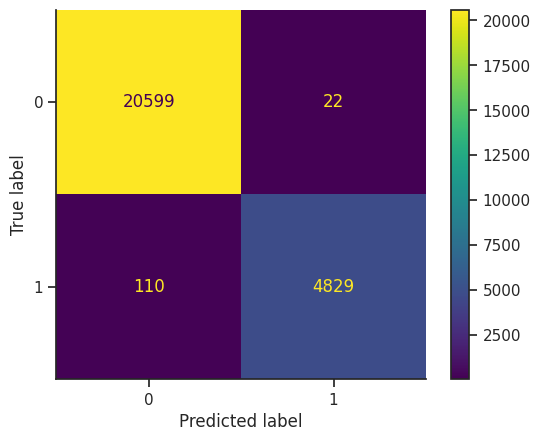

In [ ]:
# Plotando a Matriz de Confusão com as predições de treino
metrics.ConfusionMatrixDisplay.from_predictions(train_y, train_predictions_rfc);

Já percebe-se que este modelo se saiu muito melhor, porém poder ser o indicativo de um overfitting.

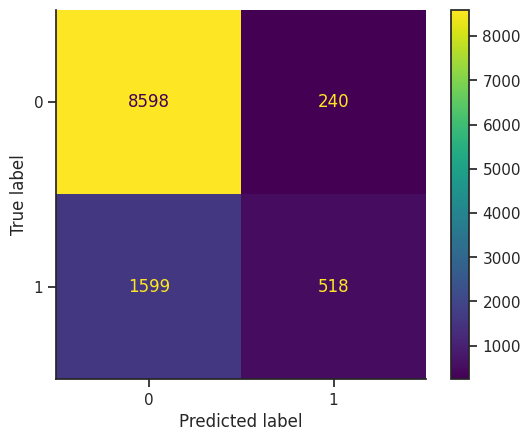

In [ ]:
# Plotando a matriz com as predições de teste
metrics.ConfusionMatrixDisplay.from_predictions(test_y, test_predictions_rfc);

Realmente, é um caso de overfitting. O modelo "decorou" os dados de treino e por isso se saiu melhor. Contudo, ao receber os dados de teste, sua performace caiu.

In [ ]:
# Criando um dicionário com as métricas para treino e teste
metricas_rfc = {
    'model': ['Random Forest Classifier', 'Random Forest Classifier'],
    'modo': ['treino', 'teste'],
    'accuracy': [metrics.accuracy_score(train_y, train_predictions_rfc), metrics.accuracy_score(test_y, test_predictions_rfc)],
    'balanced accuracy': [metrics.balanced_accuracy_score(train_y, train_predictions_rfc), metrics.balanced_accuracy_score(test_y, test_predictions_rfc)],
    'precision': [metrics.precision_score(train_y, train_predictions_rfc), metrics.precision_score(test_y, test_predictions_rfc)],
    'recall': [metrics.recall_score(train_y, train_predictions_rfc), metrics.recall_score(test_y, test_predictions_rfc)],
    'f1-score': [metrics.f1_score(train_y, train_predictions_rfc), metrics.f1_score(test_y, test_predictions_rfc)],
    'ROC AUC score': [metrics.roc_auc_score(train_y, rfc.predict_proba(train_X_std)[:,1]), metrics.roc_auc_score(test_y, rfc.predict_proba(test_X_std)[:,1])]
}

In [ ]:
# Plotando as métricas do modelo em um DataFrame
metricas_rfc = pd.DataFrame(metricas_rfc)
metricas_rfc

,model,modo,accuracy,balanced accuracy,precision,recall,f1-score,ROC AUC score
0,Random Forest Classifier,treino,0.994836,0.988331,0.995465,0.977728,0.986517,0.999809
1,Random Forest Classifier,teste,0.832131,0.608765,0.683377,0.244686,0.360348,0.672574


Observando agora as métricas do modelo, nota-se que realmente houve um overfitting no treino, e por isso sua performance decaiu no teste.

### Model Comparison

Efentuando uma comparação entre os modelos treinados e testados.

In [ ]:
ranking_table = pd.concat([metricas_lrc, metricas_rfc], ignore_index=True)
ranking_table

,model,modo,accuracy,balanced accuracy,precision,recall,f1-score,ROC AUC score
0,Logistic Regression,treino,0.806768,0.500000,0.000000,0.000000,0.000000,0.514712
1,Logistic Regression,teste,0.806755,0.500000,0.000000,0.000000,0.000000,0.491249
2,Random Forest Classifier,treino,0.994836,0.988331,0.995465,0.977728,0.986517,0.999809
3,Random Forest Classifier,teste,0.832131,0.608765,0.683377,0.244686,0.360348,0.672574


In [ ]:
ranking_table.query('modo == "treino"').sort_values(by= 'ROC AUC score', ascending= False)

,model,modo,accuracy,balanced accuracy,precision,recall,f1-score,ROC AUC score
2,Random Forest Classifier,treino,0.994836,0.988331,0.995465,0.977728,0.986517,0.999809
0,Logistic Regression,treino,0.806768,0.500000,0.000000,0.000000,0.000000,0.514712


In [ ]:
ranking_table.query('modo == "teste"').sort_values(by= 'ROC AUC score', ascending= False)

,model,modo,accuracy,balanced accuracy,precision,recall,f1-score,ROC AUC score
3,Random Forest Classifier,teste,0.832131,0.608765,0.683377,0.244686,0.360348,0.672574
1,Logistic Regression,teste,0.806755,0.500000,0.000000,0.000000,0.000000,0.491249


De fato, por ser mais sofisticado, o Random Forest Classifier se saiu melhor, pois, de alguma forma, conseguiu percerber algum nuance nos dados, permitindo que identificasse os casos positivos. Contudo, sua performance decaiu no teste por não conseguir generalizar bem.

Portanto, ele será o modelo escolhido para passar por um tunning de hiperparâmetros, a fim de tentar aperfeiçoá-lo, reduzindo o overfitting e, assim, permitindo-o generalizar melhor.

### Model Tunning

In [ ]:
# Parâmetros a serem testados
parameters = {
    'class_weight': [{0: 1, 1: 4}, 'balanced'], # Peso explícito para a classe minoritária (proporção 4:1)
    'max_depth': [10, 15, None],                # Reduzir profundidade para limitar overfitting
    'min_samples_split': [20, 50, 100],         # Exige mais amostras para dividir nós.
    'min_samples_leaf': [10, 20],               # Folhas maiores evitam decisões específicas demais.
    'max_features': ['sqrt', 0.3],              # Reduz correlação entre árvores.
    'n_estimators': [200, 300]                  # Mais árvores melhoram generalização.
}

Dentro do Grid Search, no método de Cross-Validation ('cv='), será passado o StratifiedKFold para uma validação cruzada estratificada, para se assegurar que haja sempre dados balanceados em cada fold.

Além disso, o modelo será validado com foco na métrica de recall, uma vez que se busca encontrar os casos positivos.

In [ ]:
grid_search = GridSearchCV(rfc, parameters, scoring= 'recall', cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1)
grid_search.fit(train_X_std, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 4}, 'balanced'],
                         'max_depth': [10, 15, None],
                         'max_features': ['sqrt', 0.3],
                         'min_samples_leaf': [10, 20],
                         'min_samples_split': [20, 50, 100],
                         'n_estimators': [200, 300]},
             scoring='recall')

In [ ]:
# Acessando os parâmetros do melhor modelo
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Passando os hiperparâmetros otimizados para modelo
rfc_tunned = RandomForestClassifier(
  bootstrap= True,
  ccp_alpha= 0.0,
  class_weight= 'balanced',
  criterion= 'gini',
  max_depth= 10,
  max_features= 'sqrt',
  max_leaf_nodes= None,
  max_samples= None,
  min_impurity_decrease= 0.0,
  min_samples_leaf= 20,
  min_samples_split= 100,
  min_weight_fraction_leaf= 0.0,
  monotonic_cst= None,
  n_estimators= 200,
  n_jobs= None,
  oob_score= False,
  random_state= None,
  verbose= 0,
  warm_start= False
)

In [ ]:
# Treinando o modelo otimizado
rfc_tunned.fit(train_X_std, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=20, min_samples_split=100,
                       n_estimators=200)

In [ ]:
# Coletando as predições
train_predictions_rfc_tunned = rfc_tunned.predict(train_X_std)
test_predictions_rfc_tunned = rfc_tunned.predict(test_X_std)

In [ ]:
# Criando a tabela de predições de teste
table_prediction_rfc_tunned = test_X_std.assign(Prediction= test_predictions_rfc_tunned).assign(Real= test_y)
table_prediction_rfc_tunned

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,Prediction,Real
20640,0.901961,0.915972,0.0,0.0,0.75,0.0,0.0,1.0,1.0,0.0,0.0,0,0
33798,0.470588,0.369334,0.2,0.0,0.25,0.8,1.0,0.0,0.0,1.0,0.0,0,1
18914,0.333333,0.000000,1.0,0.0,0.75,0.2,1.0,0.0,1.0,0.0,0.0,1,0
29914,0.607843,0.000000,1.0,0.0,0.00,0.8,0.0,1.0,0.0,0.0,1.0,0,0
30727,0.529412,0.245918,1.0,0.0,0.50,0.6,1.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20868,0.627451,0.000000,1.0,0.0,0.50,0.6,1.0,0.0,1.0,0.0,0.0,1,0
32007,0.196078,0.072611,0.0,0.0,0.75,0.6,0.0,1.0,0.0,0.0,1.0,0,0
6943,0.980392,0.075237,0.0,0.0,0.50,0.4,1.0,0.0,0.0,0.0,1.0,0,0
7502,0.176471,0.000000,0.6,0.0,0.75,0.6,0.0,1.0,0.0,0.0,1.0,0,1


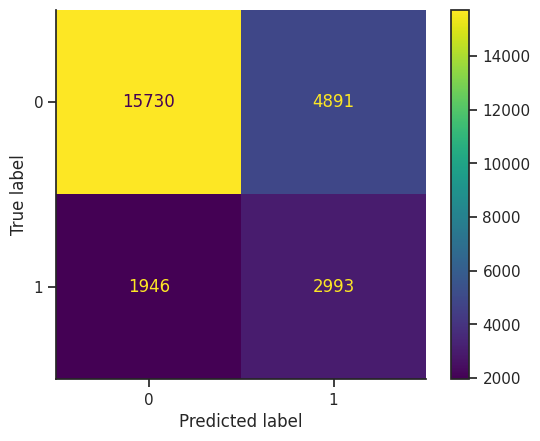

In [ ]:
# Plotando a Matriz de Confusão com as predições de treino
metrics.ConfusionMatrixDisplay.from_predictions(train_y, train_predictions_rfc_tunned);

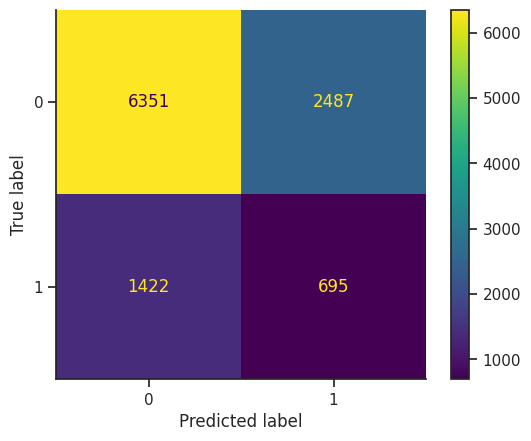

In [ ]:
# Agora, com as predições de teste
metrics.ConfusionMatrixDisplay.from_predictions(test_y, test_predictions_rfc_tunned);

In [ ]:
# Coletando as métricas do modelo
metricas_rfc_tunned = {
    'model': ['Random Forest Classifier tunned', 'Random Forest Classifier tunned'],
    'modo': ['treino', 'teste'],
    'accuracy': [metrics.accuracy_score(train_y, train_predictions_rfc_tunned), metrics.accuracy_score(test_y, test_predictions_rfc_tunned)],
    'balanced accuracy': [metrics.balanced_accuracy_score(train_y, train_predictions_rfc_tunned), metrics.balanced_accuracy_score(test_y, test_predictions_rfc_tunned)],
    'precision': [metrics.precision_score(train_y, train_predictions_rfc_tunned), metrics.precision_score(test_y, test_predictions_rfc_tunned)],
    'recall': [metrics.recall_score(train_y, train_predictions_rfc_tunned), metrics.recall_score(test_y, test_predictions_rfc_tunned)],
    'f1-score': [metrics.f1_score(train_y, train_predictions_rfc_tunned), metrics.f1_score(test_y, test_predictions_rfc_tunned)],
    'ROC AUC score': [metrics.roc_auc_score(train_y, rfc_tunned.predict_proba(train_X_std)[:,1]), metrics.roc_auc_score(test_y, rfc_tunned.predict_proba(test_X_std)[:,1])]
}

In [ ]:
# Plotando as métricas em um DataFrame
metricas_rfc_tunned = pd.DataFrame(metricas_rfc_tunned)
metricas_rfc_tunned

,model,modo,accuracy,balanced accuracy,precision,recall,f1-score,ROC AUC score
0,Random Forest Classifier tunned,treino,0.732512,0.684404,0.379630,0.605993,0.466817,0.759551
1,Random Forest Classifier tunned,teste,0.643177,0.523448,0.218416,0.328295,0.262314,0.539042


Ao se analisar os resultados, percebe-se que houve êxito em reduzir o overfitting, porém o modelo ainda não consegue generalizar melhor.

# Evaluation

Diante de todas as análises até aqui feitas, conclui-se que o modelo obtido ainda não está pronto para implementação.

Sendo necessário obter mais dados, uma vez que os dados obtidos não são suficientes para a construção de um modelo eficiente de predição. Tratam-se de dados desbalanceados cujas features não indicam qualquer padrão que possibilite identificar os casos positivos.

Portanto, é fundamental a obtenção de novos dados, talvez com novas features, para assim se poder discernir os casos positivos dos negativos.